<a href="https://colab.research.google.com/github/aaiit/Plant_Pathology_2021/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/deepakHonakeri05/yolo_dataset.git


Cloning into 'yolo_dataset'...
remote: Enumerating objects: 36553, done.
remote: Total 36553 (delta 0), reused 0 (delta 0), pack-reused 36553
Receiving objects: 100% (36553/36553), 632.83 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Checking out files: 100% (72348/72348), done.


In [2]:
import numpy as np
import cv2
import imutils
from keras.preprocessing import image as kimage
from keras.applications import ResNet50
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Convolution2D,Dropout,MaxPooling2D,GlobalAveragePooling2D,Flatten,Dense
import os
import time

In [3]:

image = cv2.imread("yolo_dataset/Apple/test/apple_black_rot/apple_BR1.jpg")
clone = image.copy()
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

try:
	os.mkdir("rotations")
except OSError:
	print("Error")
else:
	print("Done Success!")

Done Success!


In [9]:
!gdown https://drive.google.com/uc?id=18OIpMh7VN-WNqSxIwWxD74E5hOioQS0o
!gdown https://drive.google.com/uc?id=1scC2gzvyipYuz-E2n4BTTxnRV5rvEB-0
!gdown https://drive.google.com/uc?id=1MPatsPjyYNg4gz5AAcVg5Wd9QI9G9qL_

Downloading...
From: https://drive.google.com/uc?id=18OIpMh7VN-WNqSxIwWxD74E5hOioQS0o
To: /content/leaf_4200.weights
246MB [00:02, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1scC2gzvyipYuz-E2n4BTTxnRV5rvEB-0
To: /content/leaf.cfg
100% 8.34k/8.34k [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MPatsPjyYNg4gz5AAcVg5Wd9QI9G9qL_
To: /content/leaf.names
100% 5.00/5.00 [00:00<00:00, 23.6kB/s]


In [12]:
weightsPath =  "leaf_4200.weights"
configPath = "leaf.cfg"
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

labelsPath = "leaf.names"
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

[INFO] loading YOLO from disk...


In [13]:
(H, W) = image.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.563266 seconds


In [14]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [15]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
 
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.24:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
 
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
 
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [16]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.24,0.4)

Bounding boxes 


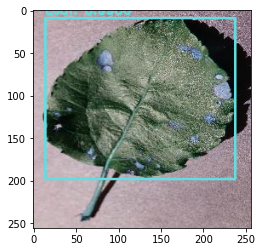

Cropped Image


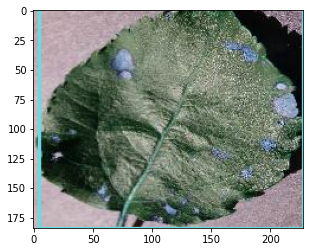

In [17]:
from matplotlib import pyplot as plt

# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
 
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
 
# show the output cropped image
fin_x = x
fin_y = y
fin_xw = y+h
fin_yh = x+w
crop_img = image[fin_x:fin_xw,fin_y:fin_yh]

print("Bounding boxes ")
plt.imshow(image)
plt.show()

print("Cropped Image")
plt.imshow(crop_img)
plt.show()
